# CIFAR10_AUGMENTATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7985786890395215610
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5724176384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5511342981608721142
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]


# Data Preprocessing

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# Data_Preprcoessing
def get_preprocessed_data(images, labels, scaling = False):
    if scaling:
        images = np.array(images / 255.0, dtype = np.float32)
    
    labels = np.array(labels, dtype = np.float32)
    
    return images, labels

# One_Hot_Encoding
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    labels = to_categorical(labels)
    return images, labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size = 0.15, random_state = 256):
    train_images, train_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_labels = get_preprocessed_ohe(test_images, test_labels)
    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size = 0.15, random_state = 256)
    
    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size = 0.15, random_state = 256)

print(train_images.shape, train_labels.shape, valid_images.shape, valid_labels.shape, test_images.shape, test_labels.shape)
    

(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


# Data Visualization

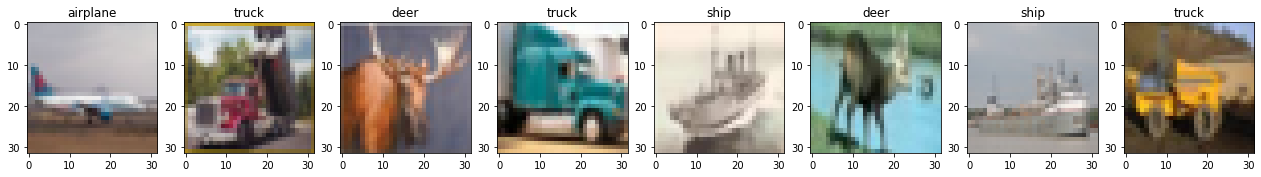

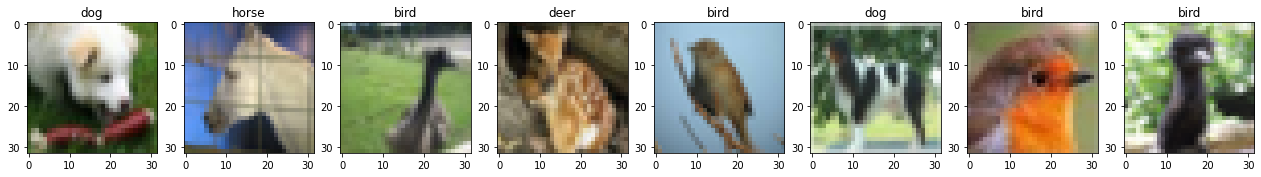

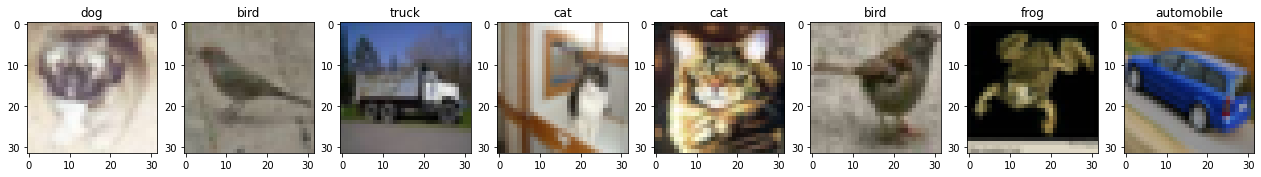

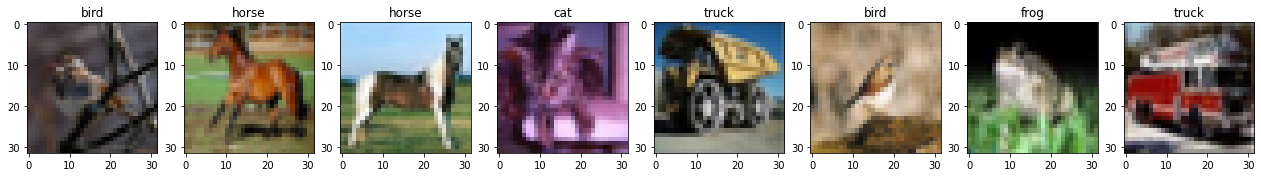

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols = 8):
    figure, axs = plt.subplots(nrows = 1, ncols = ncols, figsize = (22, 6))
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = list(labels[i].squeeze())
        axs[i].set_title(NAMES[int(label.index(1))])

show_images(train_images[:8], train_labels[:8], ncols = 8)
show_images(train_images[8:16], train_labels[8:16], ncols = 8)
show_images(train_images[16:24], train_labels[16:24], ncols = 8)
show_images(train_images[24:32], train_labels[24:32], ncols = 8)

# ImageDataGenerator로 Augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator를 사용 시 주의 할 점이 있는데, 무작정 데이터를 변형시킨다고, 성능이 좋아지는 것이 아니다.
# 데이터의 특징에 변형시키는 것이 좋습니다.
train_generator = ImageDataGenerator(
    # rotation_range = 20
    # zoom_range = (0.7, 0.9).
    horizontal_flip = True,
    # vertical_flip = True,
    rescale = 1/255.0
)

# 학습을 검증하기 위한 데이터이므로, Augmentation을 적용하면 안됩니다.
valid_generator = ImageDataGenerator(rescale = 1/255.0)

flow_tr_gen = train_generator.flow(train_images, train_labels, batch_size=64, shuffle = True)
flow_val_gen = valid_generator.flow(valid_images, valid_labels, batch_size = 64, shuffle = False)

# Keras CNN Model 생성하기

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Activation, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def Create_Models(verbose = False):
    input_tensor = Input(shape=(32, 32, 3))
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = 64, kernel_size = (3, 3 ), padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten 대신 Global AveragePooling 을 적용. 
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs = input_tensor, outputs = output)
    if verbose:
        model.summary()
    
    return model

model = Create_Models(verbose = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

In [25]:
rlp_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, mode = 'min', verbose = 1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode = 'min', verbose = 1)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(flow_tr_gen, epochs = 40, batch_size= 64,  validation_data = flow_val_gen, callbacks= [rlp_cb, ely_cb], verbose = 1)

Epoch 1/40
665/665 [==============================] - 15s 14ms/step - loss: 1.4566 - accuracy: 0.4753 - val_loss: 4.7024 - val_accuracy: 0.1053
Epoch 2/40
665/665 [==============================] - 9s 13ms/step - loss: 0.9978 - accuracy: 0.6488 - val_loss: 4.9935 - val_accuracy: 0.1423
Epoch 3/40
665/665 [==============================] - 8s 13ms/step - loss: 0.8097 - accuracy: 0.7187 - val_loss: 6.5480 - val_accuracy: 0.0996
Epoch 4/40
665/665 [==============================] - 8s 12ms/step - loss: 0.6767 - accuracy: 0.7713 - val_loss: 3.8994 - val_accuracy: 0.0997
Epoch 5/40
665/665 [==============================] - 8s 12ms/step - loss: 0.6015 - accuracy: 0.7993 - val_loss: 3.4578 - val_accuracy: 0.1005
Epoch 6/40
665/665 [==============================] - 8s 13ms/step - loss: 0.5392 - accuracy: 0.8198 - val_loss: 7.7572 - val_accuracy: 0.0996
Epoch 7/40
665/665 [==============================] - 9s 13ms/step - loss: 0.4666 - accuracy: 0.8457 - val_loss: 10.2319 - val_accuracy: 0.10

In [26]:
test_generator = ImageDataGenerator(rescale= 1/255.0)
flow_test_gen = test_generator.flow(test_images, test_labels, batch_size= 64, shuffle = False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 4ms/step - loss: 0.4626 - accuracy: 0.8862


[0.462586373090744, 0.8862000107765198]

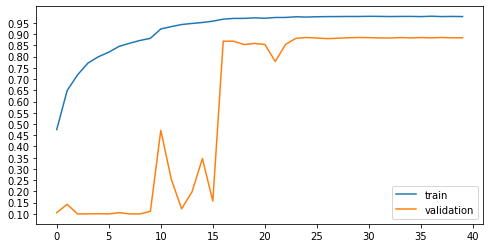

In [28]:
plt.figure(figsize=(8, 4))
plt.yticks(np.arange(0, 1, 0.05))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()

# Model Predict

In [49]:
# 예측할 때, rescale된 것으로 해야한다.
preds = model.predict(flow_test_gen)
print(preds.shape)

(10000, 10)


In [50]:
predicted_class = np.argmax(preds, axis = 1)
print('예측 클래스 값 :',predicted_class)
predicted_class[9000:9100]

예측 클래스 값 : [3 8 8 ... 5 1 7]


array([8, 1, 4, 3, 7, 5, 6, 2, 0, 2, 8, 2, 8, 7, 7, 8, 1, 0, 8, 9, 7, 0,
       3, 8, 0, 5, 0, 5, 8, 0, 2, 8, 9, 2, 4, 4, 4, 9, 2, 6, 5, 5, 1, 3,
       2, 0, 0, 4, 0, 6, 5, 8, 0, 5, 8, 6, 5, 8, 5, 2, 9, 7, 9, 7, 1, 2,
       1, 9, 6, 9, 2, 7, 9, 6, 4, 0, 6, 2, 4, 1, 3, 7, 6, 8, 5, 9, 0, 3,
       2, 3, 2, 7, 6, 3, 2, 5, 9, 0, 5, 9], dtype=int64)

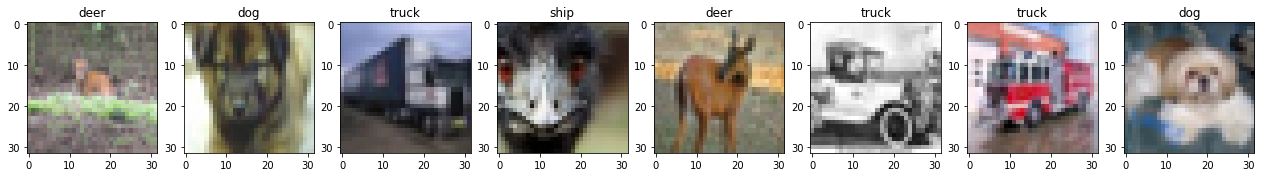

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols = 8):
    figure, axs = plt.subplots(figsize = (22, 6), nrows = 1, ncols = ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
                         
show_images(test_images[32:40], predicted_class[32:40], ncols=8)